Orbitals and basis sets

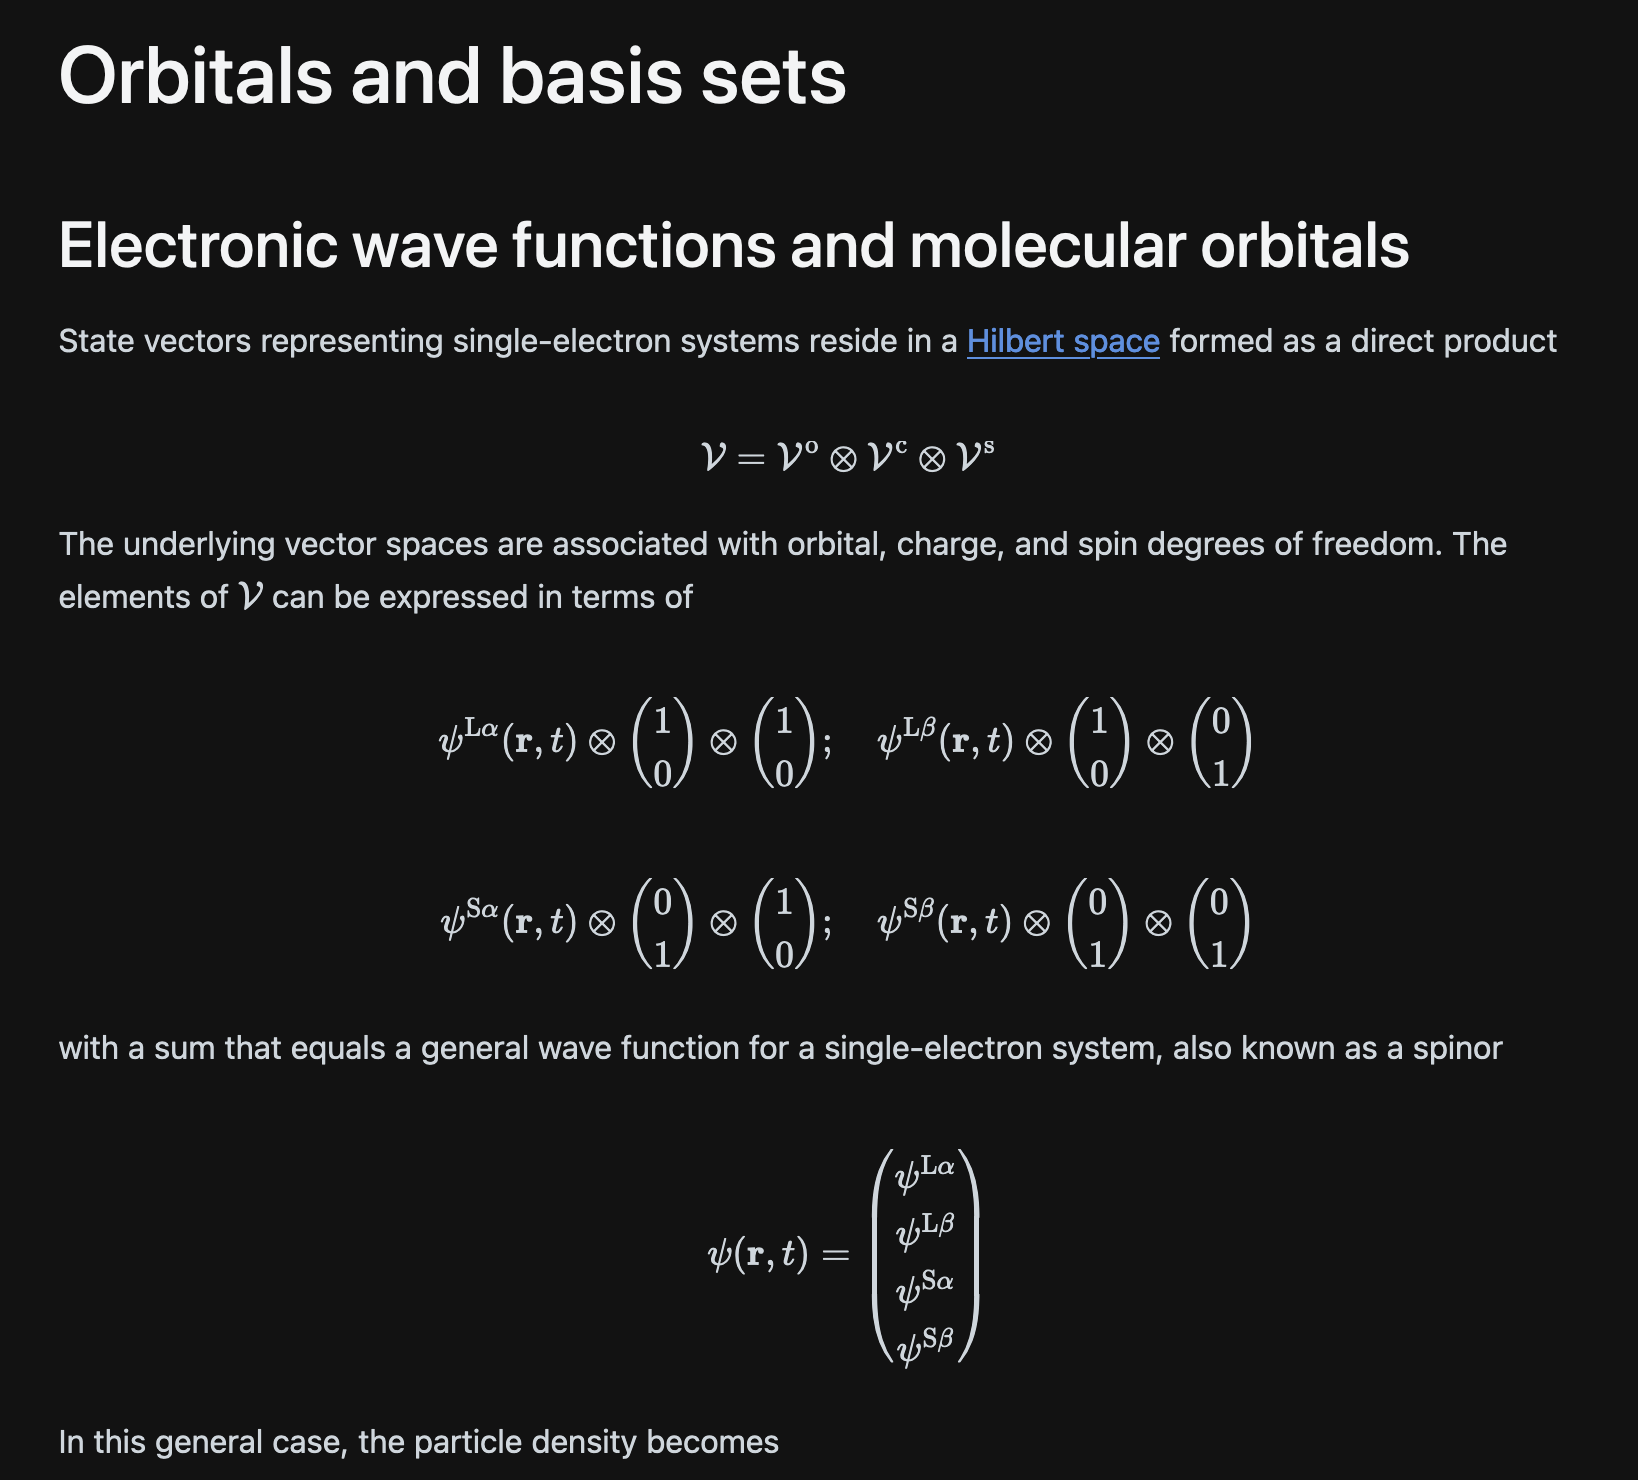

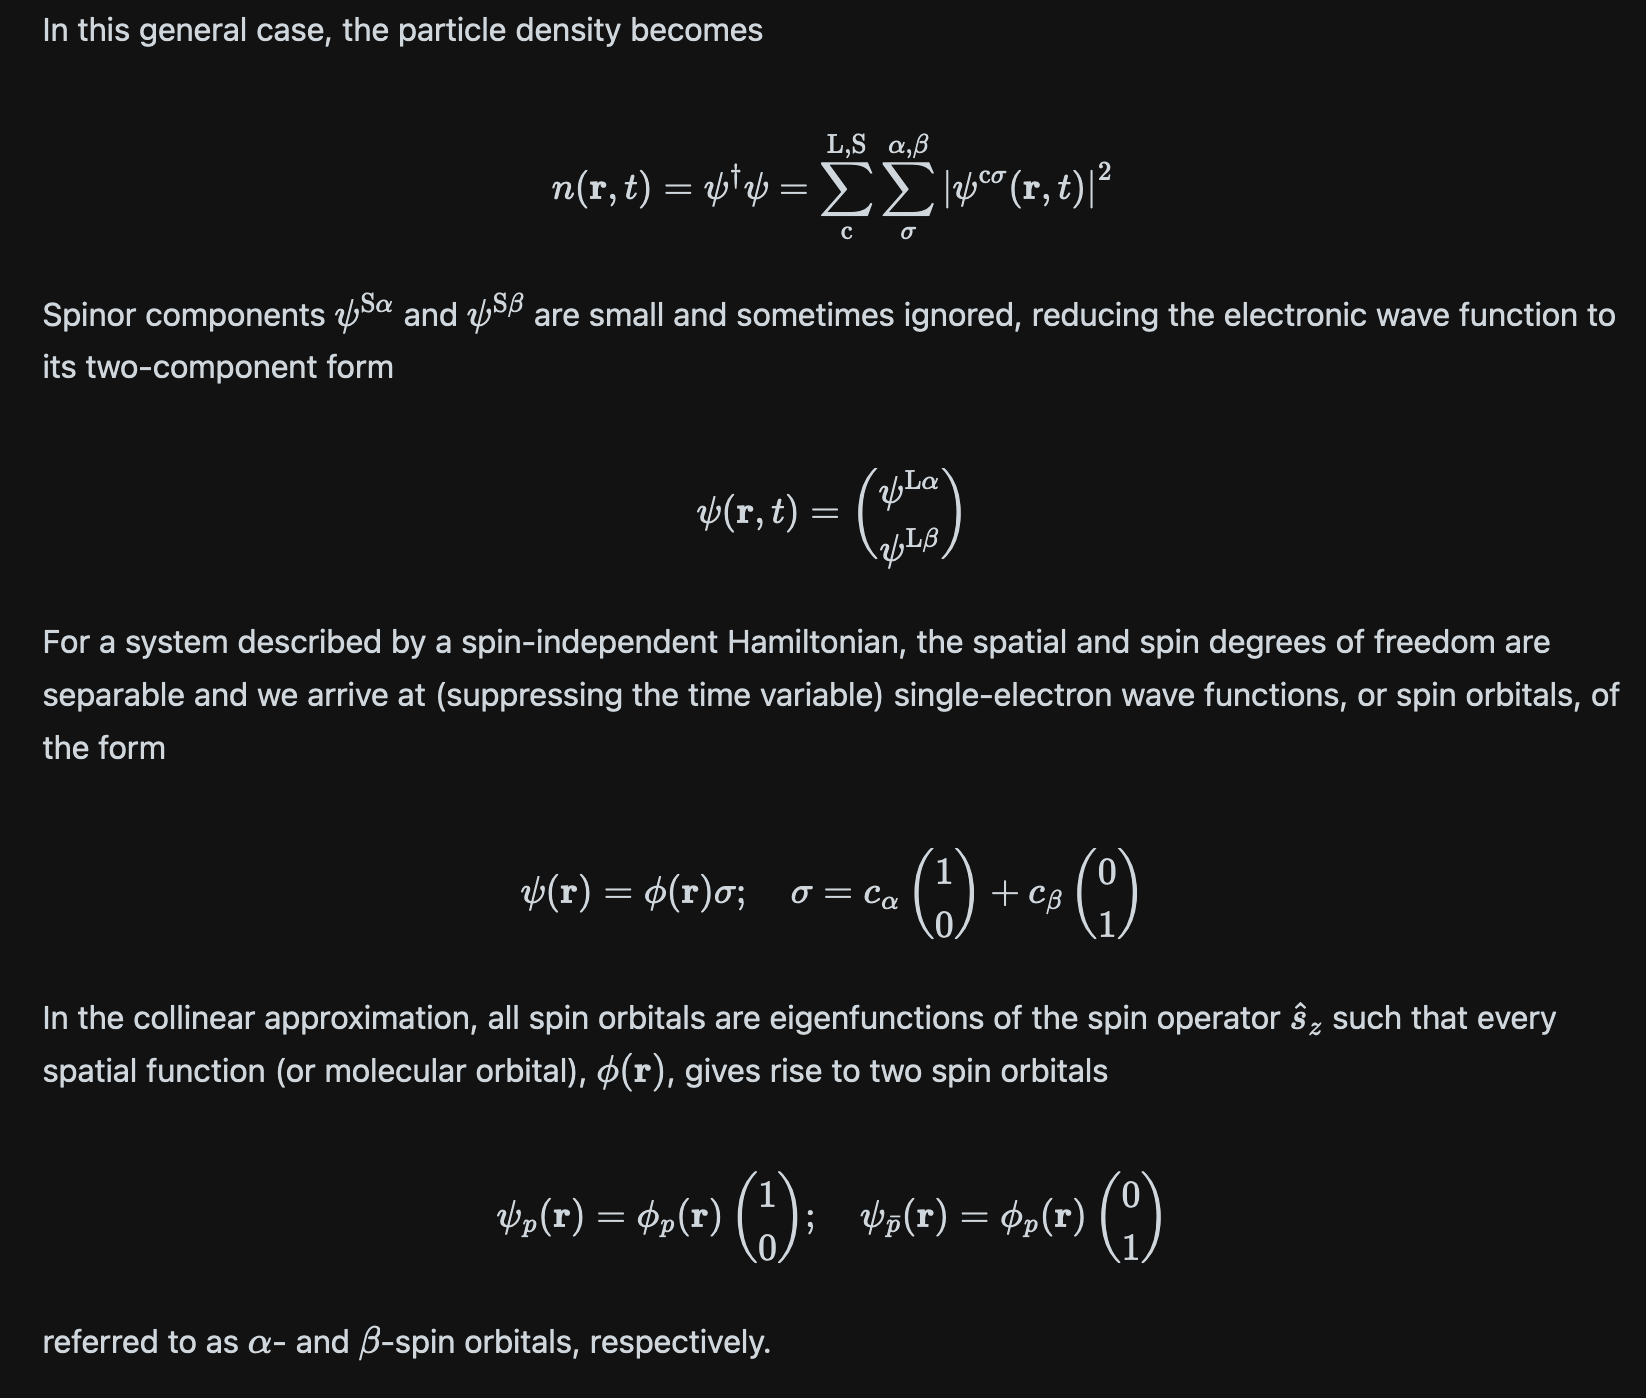

In [3]:
!pip3 install openfermion openfermionpsi4 openfermioncirq pyscf openfermionpyscf pyOpenSSL

  Using cached openfermion-1.6.1-py3-none-any.whl.metadata (10 kB)
  Using cached openfermionpsi4-0.5-py3-none-any.whl.metadata (7.6 kB)
  Using cached openfermioncirq-0.4.0-py3-none-any.whl.metadata (3.9 kB)
  Using cached pyscf-2.5.0-py3-none-macosx_10_9_x86_64.whl.metadata (3.1 kB)
  Using cached openfermionpyscf-0.5-py3-none-any.whl.metadata (6.9 kB)
  Using cached pyOpenSSL-24.1.0-py3-none-any.whl.metadata (12 kB)
  Using cached deprecation-2.1.0-py2.py3-none-any.whl.metadata (4.6 kB)
  Using cached PubChemPy-1.0.4.tar.gz (29 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 817.8 kB/s eta 0:00:00 0:00:01
  Using cached sympy-1.12-py3-none-any.whl.metadata (12 kB)
  Using cached pytest-8.1.1-py3-none-any.whl.metadata (7.6 kB)
  Using cached tqdm-4.66.2-py3-none-any.whl.metadata (57 kB)
  Using 

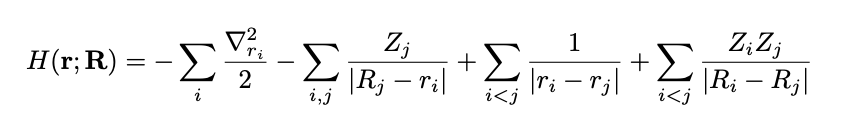

In specifying the geometry of H_2, we're assuming the Born-Oppenheimer approximation. This means we can treat the nuclei as fixed point charges and consider the ground state electronic energy as a function of the nuclei's positions.

The Hamiltonian operator (a function describing the total energy of the system) can thus be expressed as: 
where we have:

    atomic units of ℏ = 1
    𝑟𝑖, the positions of electrons
    𝑅𝑖, the positions of nuclei
    𝑍𝑖, the charges of nuclei

In our problem, our geometry is the nuclear positions, that can be specified by x, y, and z coordinates and atom labels (our two hydrogen atoms):

1.2 Spin Multiplicity

The spin multiplicity is the number of possible orientations of spin angular momentum:

𝑚𝑢𝑙𝑡𝑖𝑝𝑙𝑖𝑐𝑖𝑡𝑦=2𝑆+1

where 𝑆 is the total spin which is typically the number of unpaired electrons. Molecular hydrogen has two electrons that are pairs, so S = 0 and multiplicity = 1.

In order to know S, some intution about electronic structure (what we're looking for, a function of the bond length) is needed. So, oftentimes an iterative process is used by taking an initial guess for S, solving the system, then changing S to see which one is likely to be the most physically accurate.

1.3 Basis Set

A basis set is a set of functions combined in linear combinations to create molecular orbitals. These functions for molecular orbitals are then used to construct wavefunctions for the electronic states which describe the electronic states of molecules:

    basis sets (Gaussian functions) → molecular orbitals (sum of basis sets)→ electronic states of molecules (wavefunction)

Common basis sets expressed as sums of Gaussians can be found here. We're going to use a minimal basis set, sto-3g, 3 Gaussians used to approximate Slater-type orbitals.

In [5]:
import openfermion as of
from openfermion.chem import MolecularData

In [6]:
bond_length = 0.74
geometry = [['H', [0., 0., 0.]],
            ['H', [0., 0., bond_length]]]

In [7]:
multiplicity = 1

In [8]:
charge = 0

In [9]:
basis = 'sto-3g'

In [10]:
# define H_2 molecule
h2_molecule = MolecularData(geometry, basis, multiplicity, charge)

In [11]:
print('This molecule has {} atoms and {} electrons.'.format(
    h2_molecule.n_atoms, h2_molecule.n_electrons))
for atom, atomic_number in zip(h2_molecule.atoms, h2_molecule.protons):
    print('Contains {} atom, which has {} protons.'.format(
        atom, atomic_number))

This molecule has 2 atoms and 2 electrons.
Contains H atom, which has 1 protons.
Contains H atom, which has 1 protons.


After specifying the molecule, the electronic structure problem may be written in the form of a second quantized electronic Hamiltonian as:
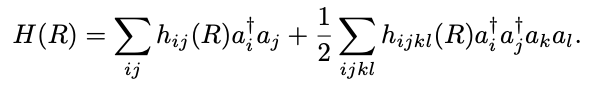

In this form we have:

    𝑅, the fixed positions of nuclei
    𝑎𝑗, 𝑎𝑘, 𝑎𝑙, the annhilation operators
    𝑎†𝑖, 𝑎†𝑗, the creation operators
    ℎ𝑖𝑗 and ℎ𝑖𝑗𝑘𝑙, the one and two-electron integerals, coefficients that depend on the physical system being described. These are defined by the basis set chosen, sto-3g. Using the OpenFermion-Psi4 plugin, these can be obtained in the MO basis in the Psi4 electronic strucutre code by executing run_psi4

We want to calculate the lowest eignvalue of this Hamiltonian, which corresponds to the ground state energy.

2.1 One and Two-Electron Integrals

ℎ𝑖𝑗 and ℎ𝑖𝑗𝑘𝑙, the one and two-electron integerals, are coefficients in the Hamiltonian that depend on the physical system being described. These are defined by the basis set chosen

run_pyscf runs a PySCF calculation for one and two-electron integrals using the Hartree-Fock method. 

In [13]:
# OpenFermionPySCF
import openfermionpyscf as ofpyscf

In [14]:
run_scf = 1
run_mp2 = 1
run_cisd = 0
run_ccsd = 0
run_fci = 1

h2_molecule = ofpyscf.run_pyscf(h2_molecule,
                    run_scf=run_scf,
                    run_mp2=run_mp2,
                    run_cisd=run_cisd,
                    run_ccsd=run_ccsd,
                    run_fci=run_fci)

The MP2, CISD, CCSD, and FCI energies are used to improve upon the Hartree-Fock method. These energies are descriptions of correlated motions of electrons (Møller and Plesset, 1934). Psi4 documentation explains that:

    MP2 (second order Møller-Plesset perturbation theory) is used for small molecules
    CISD (configuration interaction with singly and doubly subsituted determinants) can be used for larger molecules but are not size extensive (degrades as molecule size increases)
    CCSD (coupled-cluster singles and doubles) is slightly more computationally costly than MP2 and CISD, but is better suited for larger molecules with more accurate results
    FCI is the full configuration interaction


In [15]:
one_electron_integrals = h2_molecule.one_body_integrals

In [16]:
two_electron_integrals = h2_molecule.two_body_integrals

In [17]:
print(one_electron_integrals)

[[-1.25330979e+00  5.62437709e-18]
 [-1.87322143e-16 -4.75068849e-01]]


In [18]:
print(two_electron_integrals)

[[[[ 6.74755927e-01 -1.90232192e-16]
   [-1.32428305e-16  1.81210462e-01]]

  [[-1.32428305e-16  1.81210462e-01]
   [ 6.63711401e-01  1.39392155e-16]]]


 [[[-1.90232192e-16  6.63711401e-01]
   [ 1.81210462e-01  1.64813361e-16]]

  [[ 1.81210462e-01  1.64813361e-16]
   [ 1.39392155e-16  6.97651504e-01]]]]


2.2 Hamiltonian

OpenFermion calculates the Hamiltonian using the integrals we found above. To calculate, we run .get_molecular_hamiltonian()

In [19]:
# Perform electronic structure calculations and obtain Hamiltonian as an InteractionOperator
hamiltonian = ofpyscf.generate_molecular_hamiltonian(
  geometry, basis, multiplicity, charge)

# Convert to a FermionOperator
hamiltonian_ferm_op = of.get_fermion_operator(hamiltonian)
print(hamiltonian_ferm_op)

0.7151043390810812 [] +
-1.2533097866459775 [0^ 0] +
0.3373779634072241 [0^ 0^ 0 0] +
0.09060523100759853 [0^ 0^ 2 2] +
0.3373779634072241 [0^ 1^ 1 0] +
0.09060523100759853 [0^ 1^ 3 2] +
0.09060523100759853 [0^ 2^ 0 2] +
0.3318557006754068 [0^ 2^ 2 0] +
0.09060523100759853 [0^ 3^ 1 2] +
0.3318557006754068 [0^ 3^ 3 0] +
0.3373779634072241 [1^ 0^ 0 1] +
0.09060523100759853 [1^ 0^ 2 3] +
-1.2533097866459775 [1^ 1] +
0.3373779634072241 [1^ 1^ 1 1] +
0.09060523100759853 [1^ 1^ 3 3] +
0.09060523100759853 [1^ 2^ 0 3] +
0.3318557006754068 [1^ 2^ 2 1] +
0.09060523100759853 [1^ 3^ 1 3] +
0.3318557006754068 [1^ 3^ 3 1] +
0.33185570067540676 [2^ 0^ 0 2] +
0.09060523100759853 [2^ 0^ 2 0] +
0.33185570067540676 [2^ 1^ 1 2] +
0.09060523100759853 [2^ 1^ 3 0] +
-0.4750688487721779 [2^ 2] +
0.09060523100759853 [2^ 2^ 0 0] +
0.3488257522452316 [2^ 2^ 2 2] +
0.09060523100759853 [2^ 3^ 1 0] +
0.3488257522452316 [2^ 3^ 3 2] +
0.33185570067540676 [3^ 0^ 0 3] +
0.09060523100759853 [3^ 0^ 2 1] +
0.3318557006754


3.0 Ground State Energy Calculation

We can map the Hamiltonian we created hamiltonian_ferm_op, to a qubit operator using the Jordan-Wigner map, which we can call using OpenFermion's jordan_wigner function
